In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

C:\Users\ssiva\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [64]:
def arima(dataset,dep_col,d,new_col = None,p=0,q=0,init_betas = 1,init_thetas = 1,alpha = .1,epochs_ar = 10,epochs_arma = 5):
    import math
    ind_dep_col = list(dataset.columns).index(dep_col)
    dataframe = dataset[list(dataset.columns)[0:ind_dep_col] + list(dataset.columns)[ind_dep_col + 1:] + list(dataset.columns)[ind_dep_col:ind_dep_col + 1]]
    
    def difference(dataframe = dataframe,dep_col = dep_col,d = d,new_col = new_col,p = p,q = q):
        df = dataframe.copy()
        if d == 0:
            df[dep_col + ' d = %s' % '0'] = df[dep_col]
            return df
        
        if new_col == None:
            new_col = dep_col + ' d = %s' % d

        df[new_col] = 0
        for i in range(d,len(df.index)):
            diff = df.loc[i,dep_col] - df.loc[i-1,dep_col]
            if d > 1:
                for d_i in range(1,d):
                    diff = diff - (df.loc[i-d_i,dep_col] - df.loc[i-1-d_i,dep_col])
            df.loc[i,new_col] = diff 
        return df
    
    diff_df = difference()
    
    y_col = diff_df.columns[-1]
    
    def ARMA(diff_df = diff_df,d = d,y_col = y_col,p = p,q = q,init_betas = init_betas,init_thetas = init_thetas,alpha = alpha,epochs_ar = epochs_ar,epochs_arma = epochs_arma):
        betas = list(init_betas * np.ones(p))
        thetas = list(init_thetas * np.ones(q))
        betas = [init_betas] + betas
        thetas = [init_thetas] + thetas

        for ep in range(epochs_ar):
            for row in range(p,diff_df.count()[0]):
                y = diff_df.loc[row,y_col]
                beta_output_terms = []
                beta_output_terms.append((betas[0],1))
                for subtr_row in range(1,p+1):
                    beta_output_terms.append((betas[subtr_row],diff_df.loc[row-subtr_row,y_col]))
                #return output_terms
                #coeffs = betas + thetas
                beta_outputs = [x * y for (x,y) in beta_output_terms]
                beta_output = sum(beta_outputs)

                pred = beta_output
                betas[0] += alpha * (y - pred) * 1
                for coeff_ind in range(1,len(betas)):
                    betas[coeff_ind] += alpha * (y - pred) * diff_df.loc[row-coeff_ind,y_col]

                #for pred_row in range(0,row):
                diff_df.loc[row,'Prediction'] = pred
                diff_df.loc[row,'Error'] = diff_df.loc[row,y_col] - diff_df.loc[row,'Prediction']

        for row in range(p,diff_df.count()[0]):
            beta_output_terms = []
            beta_output_terms.append((betas[0],1))
            for subtr_row in range(1,p+1):
                beta_output_terms.append((betas[subtr_row],diff_df.loc[row-subtr_row,y_col]))
            beta_outputs = [x*y for (x,y) in beta_output_terms]
            beta_output = sum(beta_outputs)
            pred = beta_output
            diff_df.loc[row,'Prediction'] = pred
            diff_df.loc[row,'Error'] = diff_df.loc[row,y_col] - diff_df.loc[row,'Prediction']
            
            
        #return betas
        #return diff_df
    
        for ep in range(epochs_arma):
            for row in range(max(p,q),diff_df.count()[0]):
                y = diff_df.loc[row,y_col]
                beta_output_terms = []
                beta_output_terms.append((betas[0],1))
                for subtr_row in range(1,p+1):
                    beta_output_terms.append((betas[subtr_row],diff_df.loc[row-subtr_row,y_col]))
                #return beta_output_terms
                #coeffs = betas + thetas
                beta_outputs = [x * y for (x,y) in beta_output_terms]
                #return beta_outputs
                beta_output = sum(beta_outputs)
                
                theta_output_terms = []
                theta_output_terms.append((thetas[0],1))
                for subtr_row in range(1,q+1):
                    if math.isnan(diff_df.loc[row-subtr_row,'Error']) == False:
                        theta_output_terms.append((thetas[subtr_row],diff_df.loc[row-subtr_row,'Error']))
                    else:
                        theta_output_terms.append((thetas[subtr_row],0))
                #return theta_output_terms
                theta_outputs = [x * y for (x,y) in theta_output_terms]
                #return theta_outputs
                theta_output = sum(theta_outputs)
                #return theta_output
                output = beta_output + theta_output
                #return output
                            
                pred = output
                betas[0] += alpha * (y - pred) * 1
                for coeff_ind in range(1,len(betas)):
                    betas[coeff_ind] += alpha * (y - pred) * diff_df.loc[row-coeff_ind,y_col]
                #return betas
            
                thetas[0] += alpha * (y - pred) * 1
                for coeff_ind in range(1,len(thetas)):
                    if math.isnan(diff_df.loc[row-coeff_ind,'Error']) == False:
                        thetas[coeff_ind] += alpha * (y - pred) * diff_df.loc[row-coeff_ind,'Error']
                #return thetas
                
                # Making predictions for all previous rows based on betas and thetas
                for row in range(max(p,q),diff_df.count()[0]):
                    beta_output_terms = []
                    beta_output_terms.append((betas[0],1))
                    for subtr_row in range(1,p+1):
                        beta_output_terms.append((betas[subtr_row],diff_df.loc[row-subtr_row,y_col]))
                    beta_outputs = [x*y for (x,y) in beta_output_terms]
                    
                    beta_output = sum(beta_outputs)
                    
                    theta_output_terms = []
                    theta_output_terms.append((thetas[0],1))
                    for subtr_row in range(1,q+1):
                        if math.isnan(diff_df.loc[row-subtr_row,'Error']) == False:
                            theta_output_terms.append((thetas[subtr_row],diff_df.loc[row-subtr_row,'Error']))
                        else:
                            theta_output_terms.append((thetas[subtr_row],0))
                    theta_outputs = [x * y for (x,y) in theta_output_terms]
                    theta_output = sum(theta_outputs)
                    
                    output = beta_output + theta_output
                    pred = output
                    diff_df.loc[row,'Prediction'] = pred
                    diff_df.loc[row,'Error'] = diff_df.loc[row,y_col] - diff_df.loc[row,'Prediction']

                #return betas,thetas
        #return betas,thetas
        return diff_df
#         return betas
#         return betas,thetas
    
    final_df= ARMA()
#     z_df = ARMA()
#     def convert_diff_df(diff_df = z_df,d= d)
    
    return final_df
    return diff_df

In [2]:
plt.rcParams['figure.figsize'] = (12,6)

In [3]:
sns.set_style('darkgrid')

In [7]:
shampoo = pd.read_csv(r'C:\Users\ssiva\OneDrive\Documents\Machine Learning_\Machine Learning\Shampoo Timeseries\shampoo.csv')

In [8]:
shampoo.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [10]:
shampoo.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [11]:
shampoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
Month    36 non-null object
Sales    36 non-null float64
dtypes: float64(1), object(1)
memory usage: 656.0+ bytes


In [12]:
shampoo.describe()

,Sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


In [13]:
shampoo['Month'].head()

0    1-01
1    1-02
2    1-03
3    1-04
4    1-05
Name: Month, dtype: object

In [14]:
shampoo['Month_in_Year'] = shampoo['Month'].apply(lambda month: int(month.split('-')[1]))

In [15]:
shampoo

,Month,Sales,Month_in_Year
0,1-01,266.0,1
1,1-02,145.9,2
2,1-03,183.1,3
3,1-04,119.3,4
4,1-05,180.3,5
5,1-06,168.5,6
6,1-07,231.8,7
7,1-08,224.5,8
8,1-09,192.8,9
9,1-10,122.9,10


In [16]:
shampoo['Year'] = shampoo['Month'].apply(lambda month: int(month.split('-')[0]))

In [17]:
shampoo

,Month,Sales,Month_in_Year,Year
0,1-01,266.0,1,1
1,1-02,145.9,2,1
2,1-03,183.1,3,1
3,1-04,119.3,4,1
4,1-05,180.3,5,1
5,1-06,168.5,6,1
6,1-07,231.8,7,1
7,1-08,224.5,8,1
8,1-09,192.8,9,1
9,1-10,122.9,10,1


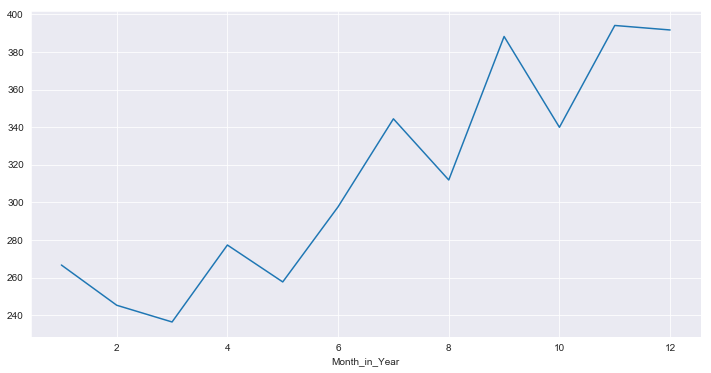

In [18]:
shampoo.groupby('Month_in_Year').mean()['Sales'].plot()

In [19]:
shampoo.groupby('Year').mean()['Sales']

Year
1    196.458333
2    262.791667
3    478.550000
Name: Sales, dtype: float64

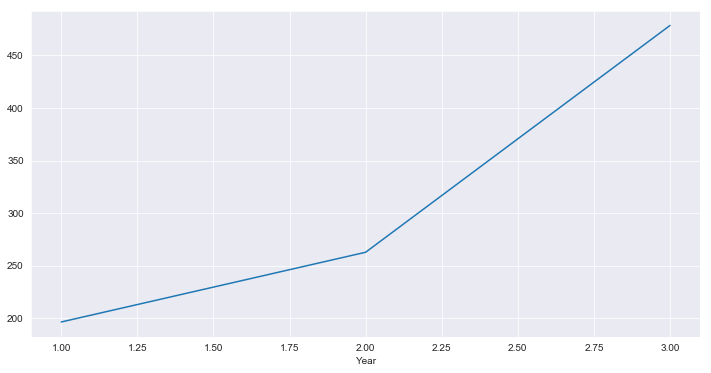

In [394]:
shampoo.groupby('Year').mean()['Sales'].plot()

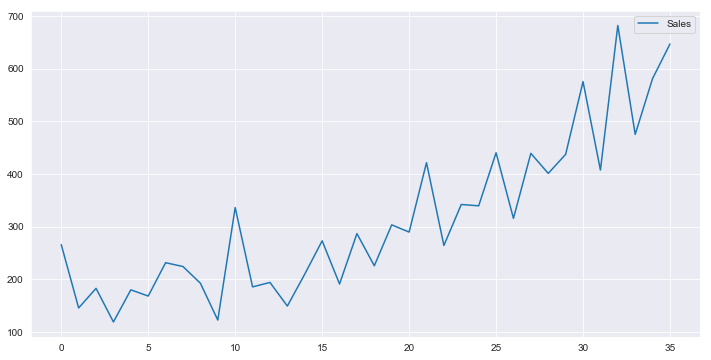

In [20]:
shampoo[['Month','Sales']].plot()

In [21]:
shampoo['Datetime'] = shampoo['Month'].apply(lambda date: pd.datetime(month = int(date.split('-')[1]), day = 1,year = 2016 + int(date.split('-')[0])))

In [22]:
shampoo

,Month,Sales,Month_in_Year,Year,Datetime
0,1-01,266.0,1,1,2017-01-01
1,1-02,145.9,2,1,2017-02-01
2,1-03,183.1,3,1,2017-03-01
3,1-04,119.3,4,1,2017-04-01
4,1-05,180.3,5,1,2017-05-01
5,1-06,168.5,6,1,2017-06-01
6,1-07,231.8,7,1,2017-07-01
7,1-08,224.5,8,1,2017-08-01
8,1-09,192.8,9,1,2017-09-01
9,1-10,122.9,10,1,2017-10-01


In [36]:
shampoo.iloc[shampoo.index[-1]]['Sales']

646.9

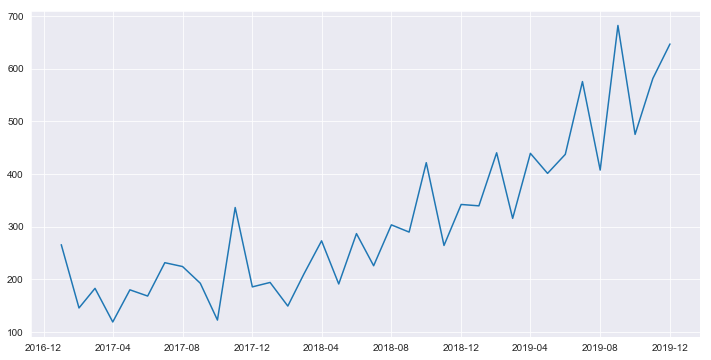

In [23]:
plt.plot(shampoo['Datetime'],shampoo['Sales'])

In [39]:
from datetime import timedelta

In [45]:
shampoo.iloc[shampoo.index[-1]]['Datetime']

Timestamp('2019-12-01 00:00:00')

In [204]:
def arima(dataset,dep_col,d,new_col = None,p=0,q=0,init_betas = 1,init_thetas = 1,alpha = .1,epochs_ar = 10,epochs_arma = 5,date_col = 'Datetime',time_increment = 'month',num_new_pred= 12):
    import math
    from datetime import timedelta
    
    ind_dep_col = list(dataset.columns).index(dep_col)
    dataframe = dataset[list(dataset.columns)[0:ind_dep_col] + list(dataset.columns)[ind_dep_col + 1:] + list(dataset.columns)[ind_dep_col:ind_dep_col + 1]]
    
    def difference(dataframe = dataframe,dep_col = dep_col,d = d,new_col = new_col,p = p,q = q):
        df = dataframe.copy()
        if d == 0:
            df[dep_col + ' d = %s' % '0'] = df[dep_col]
            return df
        
        if new_col == None:
            new_col = dep_col + ' d = %s' % d

        df[new_col] = 0
        for i in range(d,len(df.index)):
            diff = df.loc[i,dep_col] - df.loc[i-1,dep_col]
            if d > 1:
                for d_i in range(1,d):
                    diff = diff - (df.loc[i-d_i,dep_col] - df.loc[i-1-d_i,dep_col])
            df.loc[i,new_col] = diff 
        return df
    
    diff_df = difference()
    
    y_col = diff_df.columns[-1]
    
    def ARMA(diff_df = diff_df,d = d,y_col = y_col,p = p,q = q,init_betas = init_betas,init_thetas = init_thetas,alpha = alpha,epochs_ar = epochs_ar,epochs_arma = epochs_arma):
        betas = list(init_betas * np.ones(p))
        thetas = list(init_thetas * np.ones(q))
        betas = [init_betas] + betas
        thetas = [init_thetas] + thetas
        if p == q and p == 0:
            for ep in range(epochs_ar):
                for row in range(p,diff_df.count()[0]):
                    y = diff_df.loc[row,y_col]
                    beta_output_terms = []
                    beta_output_terms.append((betas[0],1))
                    for subtr_row in range(1,p+1):
                        beta_output_terms.append((betas[subtr_row],diff_df.loc[row-subtr_row,y_col]))
                    #return output_terms
                    #coeffs = betas + thetas
                    beta_outputs = [x * y for (x,y) in beta_output_terms]
                    beta_output = sum(beta_outputs)

                    pred = beta_output
                    betas[0] += alpha * (y - pred) * 1
                    for coeff_ind in range(1,len(betas)):
                        betas[coeff_ind] += alpha * (y - pred) * diff_df.loc[row-coeff_ind,y_col]

                    #for pred_row in range(0,row):
                    diff_df.loc[row,'Prediction'] = pred
                    diff_df.loc[row,'Error'] = diff_df.loc[row,y_col] - diff_df.loc[row,'Prediction']

            for row in range(p,diff_df.count()[0]):
                beta_output_terms = []
                beta_output_terms.append((betas[0],1))
                for subtr_row in range(1,p+1):
                    beta_output_terms.append((betas[subtr_row],diff_df.loc[row-subtr_row,y_col]))
                beta_outputs = [x*y for (x,y) in beta_output_terms]
                beta_output = sum(beta_outputs)
                pred = beta_output
                diff_df.loc[row,'Prediction'] = pred
                diff_df.loc[row,'Error'] = diff_df.loc[row,y_col] - diff_df.loc[row,'Prediction']


            for ep in range(epochs_arma):
                for row in range(max(p,q),diff_df.count()[0]):
                    y = diff_df.loc[row,y_col]
                    beta_output_terms = []
                    beta_output_terms.append((betas[0],1))
                    for subtr_row in range(1,p+1):
                        beta_output_terms.append((betas[subtr_row],diff_df.loc[row-subtr_row,y_col]))
                    #return beta_output_terms
                    #coeffs = betas + thetas
                    beta_outputs = [x * y for (x,y) in beta_output_terms]
                    #return beta_outputs
                    beta_output = sum(beta_outputs)

                    theta_output_terms = []
                    theta_output_terms.append((thetas[0],1))
                    for subtr_row in range(1,q+1):
                        if math.isnan(diff_df.loc[row-subtr_row,'Error']) == False:
                            theta_output_terms.append((thetas[subtr_row],diff_df.loc[row-subtr_row,'Error']))
                        else:
                            theta_output_terms.append((thetas[subtr_row],0))
                    #return theta_output_terms
                    theta_outputs = [x * y for (x,y) in theta_output_terms]
                    #return theta_outputs
                    theta_output = sum(theta_outputs)
                    #return theta_output
                    output = beta_output + theta_output
                    #return output

                    pred = output
                    betas[0] += alpha * (y - pred) * 1
                    for coeff_ind in range(1,len(betas)):
                        betas[coeff_ind] += alpha * (y - pred) * diff_df.loc[row-coeff_ind,y_col]
                    #return betas

                    thetas[0] += alpha * (y - pred) * 1
                    for coeff_ind in range(1,len(thetas)):
                        if math.isnan(diff_df.loc[row-coeff_ind,'Error']) == False:
                            thetas[coeff_ind] += alpha * (y - pred) * diff_df.loc[row-coeff_ind,'Error']
                    #return thetas

                    # Making predictions for all previous rows based on betas and thetas
                    for row in range(max(p,q),diff_df.count()[0]):
                        beta_output_terms = []
                        beta_output_terms.append((betas[0],1))
                        for subtr_row in range(1,p+1):
                            beta_output_terms.append((betas[subtr_row],diff_df.loc[row-subtr_row,y_col]))
                        beta_outputs = [x*y for (x,y) in beta_output_terms]

                        beta_output = sum(beta_outputs)

                        theta_output_terms = []
                        theta_output_terms.append((thetas[0],1))
                        for subtr_row in range(1,q+1):
                            if math.isnan(diff_df.loc[row-subtr_row,'Error']) == False:
                                theta_output_terms.append((thetas[subtr_row],diff_df.loc[row-subtr_row,'Error']))
                            else:
                                theta_output_terms.append((thetas[subtr_row],0))
                        theta_outputs = [x * y for (x,y) in theta_output_terms]
                        theta_output = sum(theta_outputs)

                        output = beta_output + theta_output
                        pred = output
                        diff_df.loc[row,'Prediction'] = pred
                        diff_df.loc[row,'Error'] = diff_df.loc[row,y_col] - diff_df.loc[row,'Prediction']

                    #return betas,thetas
        
        return diff_df
#         return betas
#         return betas,thetas
    
    final_df = ARMA()
#     z_df = ARMA()
#     def convert_diff_df(diff_df = z_df,d= d)
#     def make_predictions(dataframe = dataframe,diff_df = diff_df,num_new_pred = num_new_pred,dep_col = dep_col,date_col = date_col,time_increment = time_increment):
#         last_col = dataframe[dataframe.iloc[dataframe.index[-1]]]
#         yl = last_col[dep_col]
#         for row in range(1,num_new_pred+1):
#             if time_increment in ['Day','day','Days','days']:
#                 next_period = last_col[date_col] + timedelta(days = 1)
                
#             elif time_increment in ['Month','month','Months','months']:
#                 next_period = last_col[date_col] + timedelta(months = 1)
            
#             diff
        
                       
    return final_df
    return diff_df

In [205]:
shampoo_1_d = arima(shampoo,dep_col = 'Sales',d = 1,p=1,q=0,init_betas=10,init_thetas= 0,alpha = 0.000002,epochs_ar = 1,epochs_arma = 1)

In [206]:
shampoo_1_d

,Month,Month_in_Year,Year,Datetime,Sales,Sales d = 1
0,1-01,1,1,2017-01-01,266.0,0.0
1,1-02,2,1,2017-02-01,145.9,-120.1
2,1-03,3,1,2017-03-01,183.1,37.2
3,1-04,4,1,2017-04-01,119.3,-63.8
4,1-05,5,1,2017-05-01,180.3,61.0
5,1-06,6,1,2017-06-01,168.5,-11.8
6,1-07,7,1,2017-07-01,231.8,63.3
7,1-08,8,1,2017-08-01,224.5,-7.3
8,1-09,9,1,2017-09-01,192.8,-31.7
9,1-10,10,1,2017-10-01,122.9,-69.9


In [190]:
sum((abs(shampoo_1_d.loc[1:,'Error']))**2)**.5

AttributeError: 'tuple' object has no attribute 'loc'

In [55]:
shampoo_testing = shampoo.copy()

In [48]:
import datetime

In [52]:
shampoo_testing.loc[shampoo_testing.index[-1] + 1,'Datetime'] = 10

In [160]:
num_roll = 12

In [165]:
shampoo_testing.drop('Sales_mean',axis = 1, inplace = True)
for i in range(num_roll-1,len(shampoo_testing.index)):
    sum_vals= 0
    for num in range(0,num_roll):
        sum_vals += shampoo_testing.loc[i - num,'Sales']
    mean_vals = sum_vals / num_roll
    shampoo_testing.loc[i,'Sales_mean'] = mean_vals

In [178]:
shampoo_testing['Sales_mean']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11    196.458333
12    190.483333
13    190.783333
14    193.033333
15    205.866667
16    206.791667
17    216.666667
18    216.183333
19    222.775000
20    230.866667
21    255.758333
22    249.758333
23    262.791667
24    274.908333
25    299.150000
26    307.966667
27    321.800000
28    339.291667
29    351.825000
30    380.950000
31    389.616667
32    422.291667
33    426.766667
34    453.166667
35    478.550000
Name: Sales_mean, dtype: float64

In [180]:
shampoo_testing['Sales'].rolling(window = 12).mean()

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11    196.458333
12    190.483333
13    190.783333
14    193.033333
15    205.866667
16    206.791667
17    216.666667
18    216.183333
19    222.775000
20    230.866667
21    255.758333
22    249.758333
23    262.791667
24    274.908333
25    299.150000
26    307.966667
27    321.800000
28    339.291667
29    351.825000
30    380.950000
31    389.616667
32    422.291667
33    426.766667
34    453.166667
35    478.550000
Name: Sales, dtype: float64

NameError: name 'shampoo_1_d_small' is not defined

In [506]:
sum(abs(shampoo_1_d_small.loc[1:,'Error']))

2958.190393144489

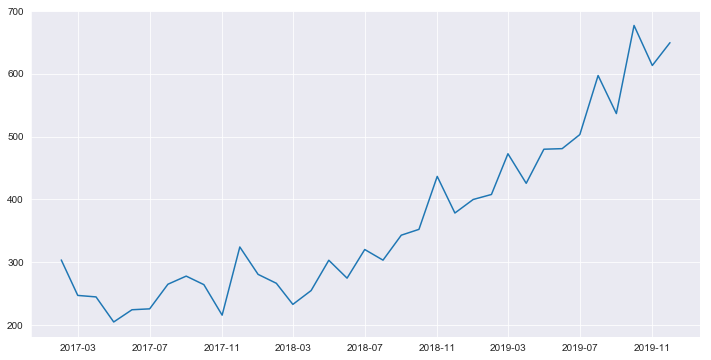

In [141]:
plt.plot(shampoo_1_d['Datetime'],shampoo_1_d['Prediction'])

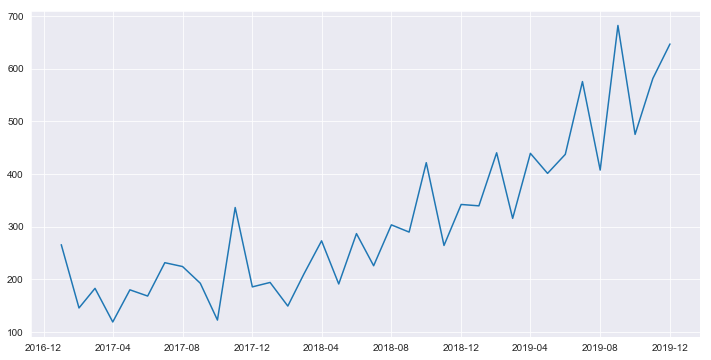

In [142]:
plt.plot(shampoo_1_d['Datetime'],shampoo_1_d['Sales d = 0'])

In [120]:
shampoo_1_d.dropna()

,Month,Month_in_Year,Year,Datetime,Sales,Sales d = 1,Prediction
9,1-10,10,1,2017-10-01,122.9,-69.9,24.865156
10,1-11,11,1,2017-11-01,336.5,213.6,43.435767
11,1-12,12,1,2017-12-01,185.9,-150.6,-126.864687
12,2-01,1,2,2018-01-01,194.3,8.4,110.230931
13,2-02,2,2,2018-02-01,149.5,-44.8,3.280640
14,2-03,3,2,2018-03-01,210.1,60.6,31.517790
15,2-04,4,2,2018-04-01,273.3,63.2,-25.283158
16,2-05,5,2,2018-05-01,191.4,-81.9,-23.309007
17,2-06,6,2,2018-06-01,287.0,95.6,50.942305
18,2-07,7,2,2018-07-01,226.0,-61.0,-46.248539


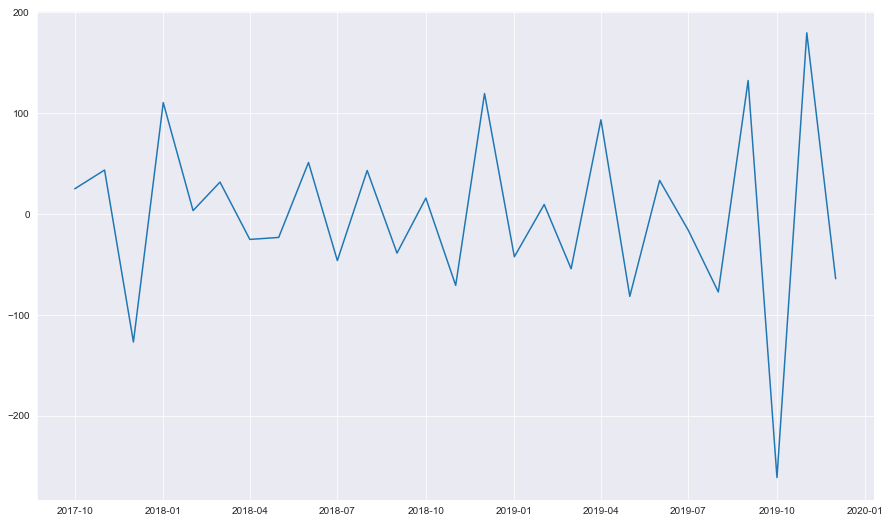

In [121]:
plt.plot(shampoo_1_d.dropna()['Datetime'], shampoo_1_d.dropna()['Prediction'])

In [155]:
shampoo_1_d['Sales d = 1'] - shampoo_1_d['Sales']

0    -266.0
1    -266.0
2    -145.9
3    -183.1
4    -119.3
5    -180.3
6    -168.5
7    -231.8
8    -224.5
9    -192.8
10   -122.9
11   -336.5
12   -185.9
13   -194.3
14   -149.5
15   -210.1
16   -273.3
17   -191.4
18   -287.0
19   -226.0
20   -303.6
21   -289.9
22   -421.6
23   -264.5
24   -342.3
25   -339.7
26   -440.4
27   -315.9
28   -439.3
29   -401.3
30   -437.4
31   -575.5
32   -407.6
33   -682.0
34   -475.3
35   -581.3
dtype: float64

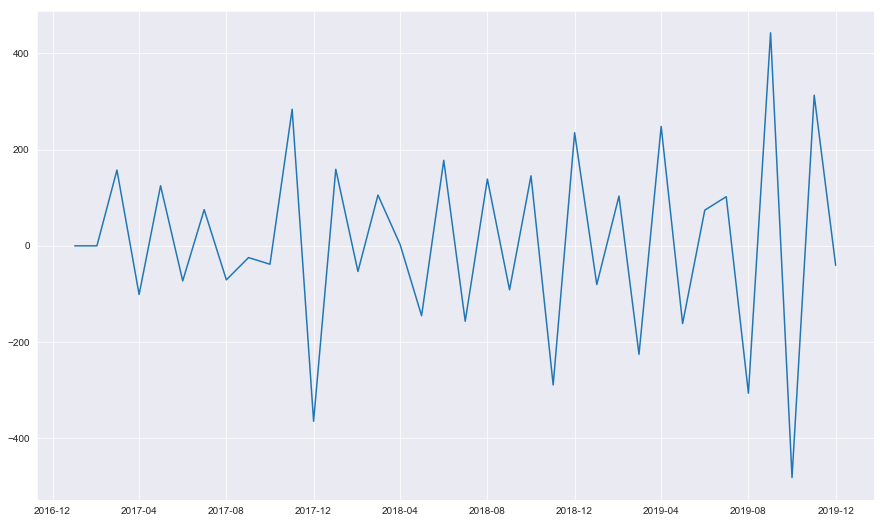

In [99]:
plt.plot(shampoo['Datetime'],shampoo['2nd Order Sales'])